### 开始

In [1]:
# 检查Python版本
from sys import version_info
if version_info.major != 3:
    
    raise Exception('请使用Python3来完成此项目')

### 寻找异常值

#### 构建分类模型

利用在ImageNet上训练过的pre-trained model对训练集进行预测，对比预测结果与真实图片是否一致，如否则属异常值

pre-trained model输出的是属于猫和狗的种类的概率，狗有118个品种， 猫有7个品种， 如何判断输出结果是猫还是狗呢？

- 如某张图的预测结果的Top-N中，既不是‘dogs',也不是'cats'，则认为此图为异常图

In [2]:
dog_breeds = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cat_breeds = [
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

### 构建预测模型

不使用generator的模型，在对多个图片分类时，占用内存太大，速度超级慢，无法实用 ----弃用

``` python
from keras.preprocessing.image import *
from keras.applications import resnet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications import inception_resnet_v2
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
import numpy as np
import h5py
import os

def predict_image(MODEL, image_size, preprocess_input, decode_predictions, top_n, image_path):
    # using the pre-training weights in ImageNet dataset
    base_model = MODEL(weights='imagenet')
    
    img = image.load_img(image_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
        
    preds = base_model.predict(x)
    
    return decode_predictions(preds, top=top_n)[0]
#     print('predicted:', decode_predictions(preds, top=3)[0])
    
def find_outlier(MODEL, image_size, model_class, model_name):
    file_list = os.listdir('train/')
    top_N = 20
    outlier_files = []
    for fname in file_list[:1000]:
        fpath = os.path.join('train/', fname)
        preds = predict_image(MODEL, image_size, 
                              model_class.preprocess_input, 
                              model_class.decode_predictions,
                             top_n = top_N,
                             image_path=fpath)
        print("decode pred:",preds)
        
        outlier_flag = True
        for pet in preds:
            if pet[0] in dog_breeds or pet[0] in cat_breeds:
                outlier_flag = False
                break;
        
        # 检查预测概率最高的品种是否错误
        if outlier_flag == False:
            pet = preds[0]
            if pet[2] > 0.6:
                if pet[0] in dog_breeds and fname[:3] == 'cat': # 指猫为'dog'
                    outlier_flag = True
                    print("Cat is not Dog")
                    
                if pet[0] in cat_breeds and fname[:3] == 'dog':
                    outlier_flag = True
                    print("Dos is not cat")
                
        if outlier_flag:
            outlier_files.append(fname)
            print('%s is a outlier !' %fname)
    
    # save the outlier to file
    out_filename = 'outlier/' + model_name + ".txt"
    with open(out_filename,'w') as f:
        f.write(str(outlier_files))
```


#### 基于生成器的模型

对指定文件夹内的图片分类，结果存入h5文件

In [16]:
model_name = "ResNet50"
def read_decode_preds_from_file(filename):
    f = open(filename,'r')
    rdbuf = f.read()
    obj = eval(rdbuf)
    f.close()
    
    return obj

decode_preds = read_decode_preds_from_file('outlier/' + model_name + "_decodepreds.txt")

print('decode_preds size:', len(decode_preds))

decode_preds size: 8


In [3]:
def find_outlier_in_decode_preds(model_name, decode_preds_set, filenames):
    outlier_files = []
    file_id = 0
    for index,decode_pred in enumerate(decode_preds_set):
        fname = filenames[index]
#         print("file name:", fname[6:9])
        ## 1st, if no dog and cat in Top-N of this prediction, this impage is a outlier
        outlier_flag = True
        for pet in decode_pred:
            if pet[0] in dog_breeds or pet[0] in cat_breeds:
                outlier_flag = False
                break;
        
        ## 2nd: 检查预测概率最高的品种是否错误
        if outlier_flag:
            print("%s is not Dog or Cat" %fname)
        else:
            pet = decode_pred[0]
            if pet[2] > 0.3:
                if pet[0] in dog_breeds and fname[6:9] == 'dog': # 指猫为'dog'
                    outlier_flag = True
                    print("%s is not cat" %fname)
                    
                if pet[0] in cat_breeds and fname[6:9] == 'dog':
                    outlier_flag = True
                    print("%s is not dog" %fname)
                
        if outlier_flag:
            outlier_files.append(fname[6:])
#             print('%s is a outlier !' %fname)
    
    # save the outlier to file
    out_filename = 'outlier/' + model_name + "_outliers.txt"
    with open(out_filename,'w') as f:
        f.write(str(outlier_files))

In [31]:
from keras.preprocessing.image import *

image_gen = ImageDataGenerator()
train_generator = image_gen.flow_from_directory('pending-clean', 
                                                target_size=(224,224), 
                                                shuffle=False, # our data will be in order
                                                batch_size=16,
                                                class_mode=None)

find_outlier_in_decode_preds("ResNet50", decode_preds, train_generator.filenames)

Found 8 images belonging to 1 classes.
train/dog.0.jpg is not cat
train/dog.5.jpg is not cat


In [ ]:
# caculate the top-N accuracy sum inp predictions
def read_decode_preds_from_file(filename):
    f = open(filename,'r')
    rdbuf = f.read()
    obj = eval(rdbuf)
    f.close()
    
    return obj

def display_top_n_acc_sum(pred):
    acc_sum = 0.0
    for pet in pred:
        acc_sum += pet[2]
        
    print('top-N accuracy sum:', acc_sum)

def show_all_preditions_top_n(decode_preds):
    for d_pred in decode_preds:
        display_top_n_acc_sum(d_pred)
        
model_name = 'ResNet50'
decode_preds = read_decode_preds_from_file('outlier/' + model_name + "_decodepreds.txt")
print("model:", model_name)
show_all_preditions_top_n(decode_preds);

In [8]:
from keras.preprocessing.image import *
from keras.applications import resnet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications import inception_resnet_v2
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
import h5py

def find_outliers(MODEL, image_size, model_class, model_name):
    image_gen = ImageDataGenerator()
    train_generator = image_gen.flow_from_directory('out_train', 
                                                target_size=image_size, 
                                                shuffle=False, # our data will be in order
                                                batch_size=16,
                                                class_mode=None)
    
    ## use pre-trained model to get features from image generator
    x = Input((image_size[0], image_size[1], 3)) # shape: width, height, channel
    ## 此处必须使用匿名函数, 要让 preprocess_input 在predict_generator时再运行， 而不是在此处
    lambda x:model_class.preprocess_input(x)
    base_model = MODEL(input_tensor=x, weights='imagenet')
    
    model = Model(inputs=base_model.input, outputs=base_model.output)
    
    # the predict_generator method returns the output of a model, given
    # a generator that yields batches of numpy data
    preds = model.predict_generator(train_generator, verbose=1)
    
    print("predicts shape:", preds.shape)
    
    # save the output to h5 file
#     out_filename = 'outlier/' + model_name + "_preds.h5"
#     with h5py.File(out_filename,'w') as h:
#         h.create_dataset("preds", data=preds)
    
    top_N = 20
    decode_preds = model_class.decode_predictions(preds, top=top_N)

    out_filename = 'outlier/' + model_name + "_decodepreds.txt"
    with open(out_filename,'w') as f:
        f.write(str(decode_preds))
        
    find_outlier_in_decode_preds(model_name, decode_preds, train_generator.filenames)


Using TensorFlow backend.


Found 5 images belonging to 1 classes.
1/1 [==============================] - 4s 4s/step
predicts shape: (5, 1000)


In [13]:
find_outlier(resnet50.ResNet50, (224,224), resnet50, "ResNet50")

decode pred: [('n02124075', 'Egyptian_cat', 0.56555563), ('n02123045', 'tabby', 0.28696027), ('n02127052', 'lynx', 0.051270023), ('n02123159', 'tiger_cat', 0.035105415), ('n04209239', 'shower_curtain', 0.012346651), ('n02808440', 'bathtub', 0.0040852465), ('n02971356', 'carton', 0.0040702336), ('n04589890', 'window_screen', 0.003119407), ('n03958227', 'plastic_bag', 0.0023623363), ('n04493381', 'tub', 0.0022657104), ('n02808304', 'bath_towel', 0.0019139963), ('n02325366', 'wood_rabbit', 0.0017331188), ('n02114855', 'coyote', 0.0016469031), ('n02326432', 'hare', 0.0014933287), ('n04553703', 'washbasin', 0.0013880422), ('n02120505', 'grey_fox', 0.0011291141), ('n02909870', 'bucket', 0.0010200642), ('n04070727', 'refrigerator', 0.0009789072), ('n03223299', 'doormat', 0.00089990476), ('n03443371', 'goblet', 0.00082443375)]
decode pred: [('n02123045', 'tabby', 0.73149043), ('n02123159', 'tiger_cat', 0.19419812), ('n02124075', 'Egyptian_cat', 0.019166976), ('n02127052', 'lynx', 0.019048095),

In [11]:
find_outlier(xception.Xception, (299,299), xception.preprocess_input, "Xception")

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 49s 62ms/step


In [ ]:
find_outlier(inception_resnet_v2.InceptionResNetV2, (299,299), inception_resnet_v2.preprocess_input,"InceptionResNetV2")

### 剔除异常值

把'train/'图片复制到'clear-train/', 把outlier list中的文件从'clear-train/'中删除

In [5]:
def read_outliers_from_file(filename):
    f = open(filename,'r')
    rdbuf = f.read()
    obj = eval(rdbuf)
    f.close()
    
    return obj

# outlier_files = []
# outlier_files += read_outliers_from_file('outlier/ResNet50.txt')
# outlier_files += read_outliers_from_file('outlier/Xception.txt')
# outlier_files += read_outliers_from_file('outlier/InceptionResNetV2.txt')
# print(outlier_files)

### 从各pre-trained model生成的outlier list中筛选出真正的outlier

筛选原理：   各模型的并集作为最后的outliers

In [7]:
models_name = ['ResNet50','Xception','InceptionResNetV2']

model_outliers = []
## -----
# for idx in range(len(models_name)):
#     fname = 'outlier/' + models_name[idx] + '_outliers.txt'
#     model_outliers.append(set(read_outliers_from_file(fname)))
    
# real_outliers = model_outliers[0]
# for i in range(1,3):
#     real_outliers &= model_outliers[i]
##-----
#    非猫非狗图片
for m_name in models_name:
    fname = 'outlier/' + m_name + '_outliers.txt'
    outlier_list = read_outliers_from_file(fname)
    print('model:', m_name)
    print('outlier num: %d' %len(outlier_list))
    model_outliers += outlier_list

real_outliers = set(model_outliers)
print('total outliers: ', len(real_outliers))
print('real outliers:', real_outliers)

wfielname = "outlier/real_outliers.txt"
with open(wfielname,'w') as f:
        f.write(str(real_outliers))

model: ResNet50
outlier num: 45
model: Xception
outlier num: 34
model: InceptionResNetV2
outlier num: 36
total outliers:  64
real outliers: {'cat.10636.jpg', 'dog.10161.jpg', 'dog.2614.jpg', 'cat.7564.jpg', 'cat.7377.jpg', 'cat.3216.jpg', 'dog.2422.jpg', 'dog.11266.jpg', 'cat.5071.jpg', 'cat.6345.jpg', 'dog.1773.jpg', 'cat.8456.jpg', 'dog.10190.jpg', 'cat.8921.jpg', 'cat.10029.jpg', 'cat.3004.jpg', 'cat.9171.jpg', 'dog.4218.jpg', 'cat.5418.jpg', 'cat.5974.jpg', 'dog.1895.jpg', 'cat.2520.jpg', 'cat.9983.jpg', 'dog.4507.jpg', 'cat.4338.jpg', 'dog.9188.jpg', 'dog.9517.jpg', 'cat.4308.jpg', 'dog.6475.jpg', 'cat.10365.jpg', 'dog.10237.jpg', 'cat.8470.jpg', 'dog.1625.jpg', 'dog.4367.jpg', 'dog.11299.jpg', 'cat.10536.jpg', 'cat.5351.jpg', 'dog.5604.jpg', 'dog.10747.jpg', 'cat.7464.jpg', 'dog.1259.jpg', 'cat.4688.jpg', 'cat.12272.jpg', 'dog.3889.jpg', 'dog.8898.jpg', 'dog.7706.jpg', 'cat.10712.jpg', 'cat.11184.jpg', 'cat.12476.jpg', 'cat.7968.jpg', 'dog.8736.jpg', 'dog.6725.jpg', 'cat.1139.jpg

In [18]:

total_outliers=['cat.10636.jpg', 'dog.10161.jpg', 'dog.2614.jpg', 'cat.7564.jpg', 'cat.7377.jpg', 'cat.3216.jpg', 'dog.2422.jpg', 'dog.11266.jpg', 'cat.5071.jpg', 'cat.6345.jpg', 'dog.1773.jpg', 'cat.8456.jpg', 'dog.10190.jpg', 'cat.8921.jpg', 'cat.10029.jpg', 'cat.3004.jpg', 'cat.9171.jpg', 'dog.4218.jpg', 'cat.5418.jpg', 'cat.5974.jpg', 'dog.1895.jpg', 'cat.2520.jpg', 'cat.9983.jpg', 'dog.4507.jpg', 'cat.4338.jpg', 'dog.9188.jpg', 'dog.9517.jpg', 'cat.4308.jpg', 'dog.6475.jpg', 'cat.10365.jpg', 'dog.10237.jpg', 'cat.8470.jpg', 'dog.1625.jpg', 'dog.4367.jpg', 'dog.11299.jpg', 'cat.10536.jpg', 'cat.5351.jpg', 'dog.5604.jpg', 'dog.10747.jpg', 'cat.7464.jpg', 'dog.1259.jpg', 'cat.4688.jpg', 'cat.12272.jpg', 'dog.3889.jpg', 'dog.8898.jpg', 'dog.7706.jpg', 'cat.10712.jpg', 'cat.11184.jpg', 'cat.12476.jpg', 'cat.7968.jpg', 'dog.8736.jpg', 'dog.6725.jpg', 'cat.1139.jpg', 'cat.6348.jpg', 'dog.12376.jpg', 'dog.2339.jpg', 'dog.11437.jpg', 'dog.10801.jpg', 'cat.12424.jpg', 'dog.1194.jpg', 'dog.7076.jpg', 'cat.11039.jpg', 'cat.3672.jpg', 'cat.2939.jpg']

total_outliers.remove('cat.1139.jpg')
total_outliers.remove('cat.3004.jpg')
total_outliers.remove('dog.7706.jpg')

print(len(total_outliers))

61


In [ ]:
import os
import shutil

## copy real outlier to outlier/image/
if os.path.exists('outlier/image'):
    shutil.rmtree('outlier/image')
os.mkdir('outlier/image')

real_outliers = read_outliers_from_file('outlier/real_outliers.txt')
print('total of outlier file:', len(real_outliers))
for filen in real_outliers:
#     print('outlier file:', filen)
    os.symlink('../../train/'+filen, 'outlier/image/'+filen)

In [9]:
# dog is not dogs, cat is not cats
for m_name in models_name:
    fname = 'outlier/' + m_name + '_outliers2.txt'
    outlier_list = read_outliers_from_file(fname)
    print('model:', m_name)
    print('outlier num: %d' %len(outlier_list))
    model_outliers += outlier_list

real_outliers = set(model_outliers)
print('total outliers: ', len(real_outliers))
print('real outliers:', real_outliers)

wfielname = "outlier/real_outliers2.txt"
with open(wfielname,'w') as f:
        f.write(str(real_outliers))

model: ResNet50
outlier num: 30
model: Xception
outlier num: 2
model: InceptionResNetV2
outlier num: 12
total outliers:  106
real outliers: {'cat.10121.jpg', 'cat.6345.jpg', 'dog.1773.jpg', 'cat.23.jpg', 'cat.10029.jpg', 'cat.9171.jpg', 'dog.4218.jpg', 'cat.2520.jpg', 'cat.2817.jpg', 'dog.4507.jpg', 'cat.4308.jpg', 'cat.10107.jpg', 'cat.10536.jpg', 'cat.3300.jpg', 'cat.7464.jpg', 'cat.4688.jpg', 'cat.10283.jpg', 'dog.7706.jpg', 'cat.1139.jpg', 'dog.12376.jpg', 'cat.2948.jpg', 'dog.11437.jpg', 'cat.12424.jpg', 'cat.2258.jpg', 'cat.2621.jpg', 'cat.2939.jpg', 'dog.2614.jpg', 'cat.7564.jpg', 'cat.8350.jpg', 'dog.11266.jpg', 'cat.5071.jpg', 'cat.5536.jpg', 'dog.10190.jpg', 'cat.1277.jpg', 'cat.3004.jpg', 'cat.4965.jpg', 'cat.3787.jpg', 'cat.7685.jpg', 'cat.8470.jpg', 'dog.1625.jpg', 'cat.10326.jpg', 'cat.9444.jpg', 'cat.326.jpg', 'dog.1259.jpg', 'cat.12272.jpg', 'cat.11184.jpg', 'cat.7296.jpg', 'cat.906.jpg', 'dog.8736.jpg', 'cat.11039.jpg', 'cat.3672.jpg', 'cat.4976.jpg', 'cat.4773.jpg', '

In [10]:
import os
import shutil

## copy real outlier to outlier/image/
if os.path.exists('outlier/image2'):
    shutil.rmtree('outlier/image2')
os.mkdir('outlier/image2')

real_outliers = read_outliers_from_file('outlier/real_outliers2.txt')
print('total of outlier file:', len(real_outliers))
for filen in real_outliers:
#     print('outlier file:', filen)
    os.symlink('../../train/'+filen, 'outlier/image2/'+filen)

total of outlier file: 106


In [4]:
import shutil
import os

def clean_data(old_dir, clean_dir, outlier_list):
    if os.path.exists(clean_dir):
        shutil.rmtree(clean_dir)
    os.mkdir(clean_dir)
    
    file_list = os.listdir(old_dir)
    for filename in file_list:
        os.symlink('../../'+old_dir+filename, clean_dir+'/'+filename)
    
    for filename in outlier_list:
        os.remove(clean_dir+'/'+filename)
    print('clean over')

In [5]:
pending_clean_dir = 'pending-clean'
cleaned_dir = 'clean-train'

real_outliers = read_outliers_from_file('outlier/real_outliers.txt')
    
clean_data(pending_clean_dir+'/train', cleaned_dir, real_outliers)

clean over


### 探索数据集

#### 收集图片信息

In [1]:
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

train_folder = 'train'
train_imgs_info = []
for img in tqdm(os.listdir(train_folder)):
    info = cv2.imread(os.path.join(train_folder, img))
    train_imgs_info.append((info.shape, img))

ImportError: No module named 'cv2'

In [9]:
train_imgs_info[:2]

[((374, 500, 3), 'cat.9112.jpg'), ((290, 287, 3), 'cat.898.jpg')]

#### 分辨率分布

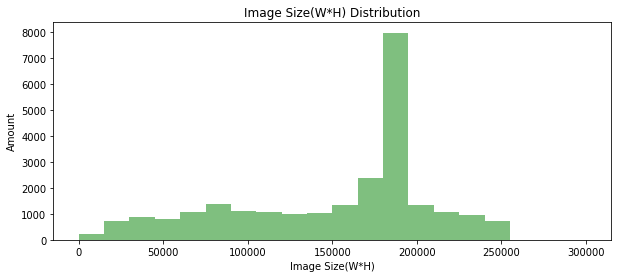

In [15]:
plt.figure(figsize=(10, 4))
img_size = [info[0][0]*info[0][1] for info in train_imgs_info]
plt.title("Image Size(W*H) Distribution")
plt.xlabel('Image Size(W*H)')
plt.ylabel('Amount')
plt.hist(img_size, bins = 20, alpha = 0.5, range = (0, 300000), color = 'g', label = 'image_size')
plt.show()

#### 训练集样本展示

In [26]:
def show_pics(folder, file_names):
    plt.figure(figsize=(12, 10))
    
    for i, file in enumerate(file_names):
        img = plt.imread(os.path.join(folder, file))
        plt.subplot(3, 4, i+1)
        plt.title(file.split('.')[0])
        plt.axis('on')
        plt.imshow(img)
        
        plt.show()

In [27]:
import random

# plt.figure(figsize=(12, 10))
file_list = os.listdir(train_folder)
sample_files = random.sample(file_list, 12)
# for i, file in enumerate(sample_files):
#     img = plt.imread(os.path.join(train_folder, file))
#     plt.subplot(3, 4, i+1)
#     plt.title(file.split('.')[0])
#     plt.axis('on')
#     plt.imshow(img)

# plt.show()
show_pics(train_folder, sample_files)

NameError: name 'train_folder' is not defined

  展示异常图片 